In [1]:
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file

from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras import regularizers, optimizers
from keras.optimizers import SGD
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import random
#import cv2
from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
import numpy as np

Using TensorFlow backend.


In [2]:


#WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'

def Xception(nb_classes):

    # Determine proper input shape
#     input_shape = _obtain_input_shape(None, default_size=299, min_size=71, data_format='channels_last', include_top=False)

#     img_input = Input(shape=input_shape)
    img_input = Input(shape=(227,227,3))

    # Block 1
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Block 2
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Block 2 Pool
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Block 3
    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Block 3 Pool
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Block 4
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Block 5 - 12
    for i in range(8):
        residual = x

        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # Block 13
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Block 13 Pool
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # Block 14
    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Block 14 part 2
    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Fully Connected Layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    x = Dense(nb_classes, activation='softmax')(x)

    inputs = img_input

    # Create model
    model = Model(inputs, x, name='xception')

    # Download and cache the Xception weights file
    #weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')

    # load weights
    #model.load_weights(weights_path)

    return model


# """
#     Instantiate the model by using the following line of code

#     model = Xception()

# """



In [3]:
def loadData(IMAGE_SIZE):
    images = os.listdir(DATA_DIR)
    d = {} 
    data_all=[]
    train_data = []
    train_pics=[]
    train_labels = []
    test_data=[]
    test_pics=[]
    test_labels=[]
    for idx, dir in enumerate(os.listdir(DATA_DIR)):
            d[idx] = dir
            label = idx
            subdir = os.path.join(DATA_DIR, dir)
            for i, file in enumerate(os.listdir(subdir)):
                #pic = cv2.imread(os.path.join(subdir, file))
                
                pic = misc.imread(os.path.join(subdir, file))
                pic = misc.imresize(pic, (IMAGE_SIZE,IMAGE_SIZE, 3))
                data_all.append((pic, label))
    np.random.shuffle(data_all)
    validation_size = int(len(data_all) * 0.40)
    #validation_data = data_all[:validation_size].copy()
    test_size = int(validation_size * 0.50)
    test_data = data_all[:test_size].copy()
    np.random.shuffle(test_data)
    #np.random.shuffle(validation_data)
    train_data = data_all[test_size:]
    for i in range(len(train_data)):
        train_pics.append(train_data[i][0])
        train_labels.append(train_data[i][1])
    for i in range(len(test_data)):
        test_pics.append(test_data[i][0])
        test_labels.append(test_data[i][1])
    return np.array(train_pics), np.array(train_labels),np.array(test_pics), np.array(test_labels)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 256 samples, validate on 64 samples
Epoch 1/5
256/256 [==============================] - 559s 2s/step - loss: 1.2224 - acc: 0.4336 - val_loss: 1.5080 - val_acc: 0.2969

Epoch 00001: val_acc improved from -inf to 0.29688, saving model to E:\分类227\weights.best.hdf5
Epoch 2/5
256/256 [==============================] - 510s 2s/step - loss: 1.0681 - acc: 0.5117 - val_loss: 8.3283 - val_acc: 0.2812

Epoch 00002: val_acc did not improve from 0.29688
Epoch 3/5
256/256 [==============================] - 502s 2s/step - loss: 0.9007 - acc: 0.6445 - val_loss: 1.8760 - val_acc: 0.5156

Epoch 00003: val_acc improved from 0.29688 to 0.51562, saving model to E:\分类227\weights.best.hdf5
Epoch 4/5
256/256 [==============================] - 494s 2s/step - loss: 0.8136 - acc: 0.6875 - val_loss: 2.7879 - val_acc: 0.4219

Epoch 00004: val_acc did not improve from 0.51562
Epoch 5/5
256/256 [==============================] - 486s 2s/step - loss: 0.6571 - acc: 0.7656 - val_loss: 1.1731 - val_acc: 0.500

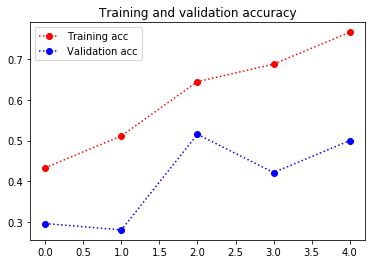

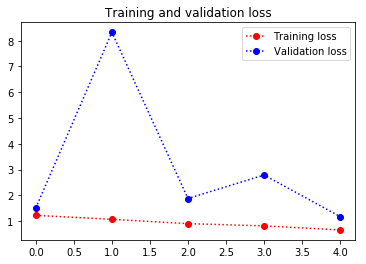

In [4]:
#np.random.seed(3)
#加载数据
IMAGE_SIZE = 227
DATA_DIR = r"E:\分类227\分类"
train_data, train_labels, test_data, test_labels = loadData(IMAGE_SIZE)
#输出训练和测试数据量
# print ("Train data size: ", len(train_data))
# print ("Test data size: ", len(test_data))

train_data=train_data.astype(np.float16)/255
test_data=test_data.astype(np.float16)/255
#将标签量进行转化
train_labels=np_utils.to_categorical(train_labels)
test_labels=np_utils.to_categorical(test_labels)
#设置检查点
# filepath=r"G:\科研\数据集\opendata_VRID\model\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
#设置最佳检查点
filepath=r"E:\分类227\weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#设置模型
num_classes=4
model=Xception(num_classes)
#编译模型
epochs = 5
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum,  decay=decay_rate, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

#匹配模型
#lrate = LearningRateScheduler(step_decay)
#callbacks_list = [lrate]
history=model.fit(train_data, train_labels,validation_split=0.2, nb_epoch=epochs,batch_size=8,callbacks=callbacks_list)
#测试模型
preds = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print (accuracy_score(test_labels, preds))
#保存模型
#model.save('squeeze-model(10,64).model')
#记录模型日志
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
#画模型准确率曲线和损失率曲线
plt.plot(epochs, acc, 'ro:', label='Training acc')
plt.plot(epochs, val_acc, 'bo:', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro:', label='Training loss')
plt.plot(epochs, val_loss, 'bo:', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('graph.png')